<a href="https://colab.research.google.com/github/Aryank47/machine_learning/blob/master/Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer

# Load the data
data = pd.read_excel('advertising_sales_data.xlsx')

In [ ]:
# 1.	What is the average amount spent on TV advertising in the dataset?
average_tv_spend = data['TV'].mean()
print(f"The average amount spent on TV advertising is ${average_tv_spend:.2f}")

The average amount spent on TV advertising is $147.04


The correlation between radio advertising and sales is 0.35


Text(0.5, 1.0, 'Correlation Heatmap')

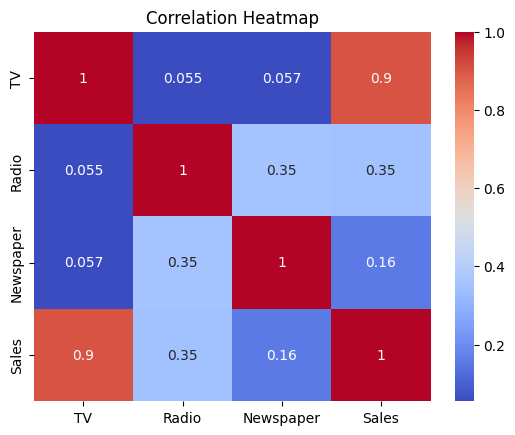

In [ ]:
# 2.	What is the correlation between radio advertising expenditure and product sales?
correlation = data['Radio'].corr(data['Sales'])
print(f"The correlation between radio advertising and sales is {correlation:.2f}")

numeric_data = data.select_dtypes(include=['float', 'int'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

In [ ]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
Campaign     0
TV           0
Radio        2
Newspaper    0
Sales        0
dtype: int64


In [ ]:
# Split features and target
X = data[['TV', 'Radio', 'Newspaper']]
y = data['Sales']


In [ ]:
# Split the data into train+validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [ ]:
print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Train set size: 160
Test set size: 40


In [ ]:
# Create a pipeline that includes imputation, scaling, and regression
numeric_features = ['TV', 'Radio', 'Newspaper']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [ ]:
# Fit the pipeline on the training data
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TV', 'Radio',
                                                   'Newspaper'])])),
                ('regressor', LinearRegression())])

In [ ]:
y_pred_test = full_pipeline.predict(X_test)

In [ ]:
print("\nModel performance on test set:")
print("R-squared:", r2_score(y_test, y_pred_test))
print("Mean squared error:", mean_squared_error(y_test, y_pred_test))


Model performance on test set:
R-squared: 0.9059941054821598
Mean squared error: 2.904885547085233



Impact of each advertising medium on sales:
     Feature  Coefficient
0         TV     4.587171
1      Radio     1.490307
2  Newspaper     0.087379


Text(0.5, 1.0, 'Feature Importance')

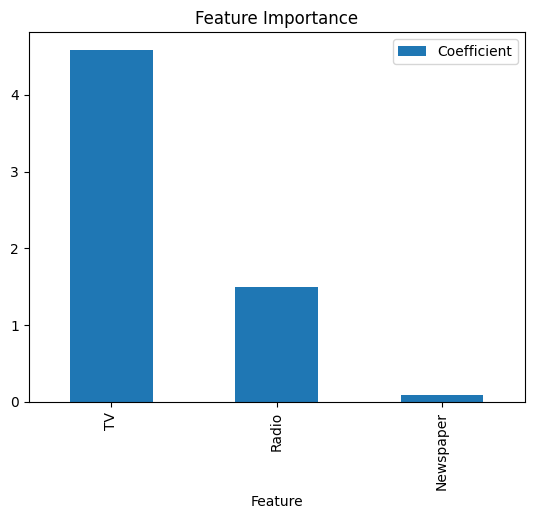

In [ ]:
# 3.Which advertising medium has the highest impact on sales based on the dataset?
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': full_pipeline.named_steps['regressor'].coef_
})
print("\nImpact of each advertising medium on sales:")
print(coefficients.sort_values('Coefficient', ascending=False))

coefficients.plot(x='Feature', y='Coefficient', kind='bar', ax=plt.gca())
plt.title('Feature Importance')

Text(0.5, 1.0, 'Residual Plot')

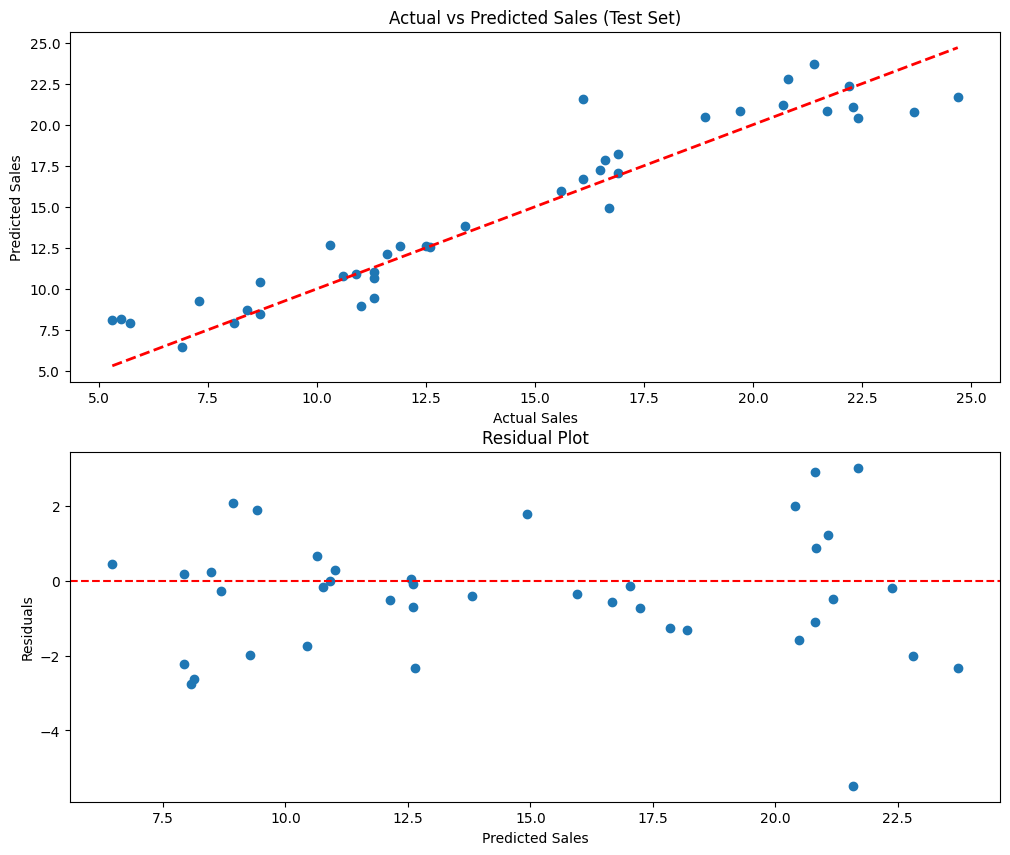

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.scatter(y_test, y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (Test Set)')

plt.subplot(2, 1, 2)
residuals = y_test - y_pred_test
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residual Plot')

In [ ]:
# 5.	How would sales be predicted for a new set of advertising expenditures: $200 on TV, $40
# on Radio, and $50 on Newspaper?
new_data = pd.DataFrame([[200, 40, 50]], columns=['TV', 'Radio', 'Newspaper'])
predicted_sales = full_pipeline.predict(new_data)
print(f"\nPredicted sales for the new advertising expenditures: ${predicted_sales[0]:.2f}")


Predicted sales for the new advertising expenditures: $19.87


In [ ]:
# 6. Compare performance with and without normalization
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])
pipeline_no_scale =  Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
pipeline_no_scale.fit(X_train, y_train)
y_pred_test_no_scale = pipeline_no_scale.predict(X_test)

print("\nNormalized model R-squared (test set):", r2_score(y_test, y_pred_test))
print("Non-normalized model R-squared (test set):", r2_score(y_test, y_pred_test_no_scale))


Normalized model R-squared (test set): 0.9059941054821598
Non-normalized model R-squared (test set): 0.9059941054821599


In [ ]:
# 7.	What is the impact on the sales prediction when only radio and newspaper advertising
# expenditures are used as predictors?
limited_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, ['Radio', 'Newspaper'])
        ])
    ),
    ('regressor', LinearRegression())
])

full_scores = cross_val_score(full_pipeline, X_train, y_train, cv=5, scoring='r2')
limited_scores = cross_val_score(limited_pipeline, X_train[['Radio', 'Newspaper']], y_train, cv=5, scoring='r2')
limited_pipeline.fit(X_train[['Radio', 'Newspaper']], y_train)
limited_y_pred_test = limited_pipeline.predict(X_test)

print(f"Full model cross-validation R2 scores: {full_scores}")
print(f"Full model mean R2 score: {full_scores.mean():.4f} (+/- {full_scores.std() * 2:.4f})")
print(f"Limited model cross-validation R2 scores: {limited_scores}")
print(f"Limited model mean R2 score: {limited_scores.mean():.4f} (+/- {limited_scores.std() * 2:.4f})")

Full model cross-validation R2 scores: [0.88977854 0.87586063 0.89894765 0.91885617 0.85639876]
Full model mean R2 score: 0.8880 (+/- 0.0422)
Limited model cross-validation R2 scores: [-0.49513619  0.07657275  0.0981037   0.17309275  0.02329927]
Limited model mean R2 score: -0.0248 (+/- 0.4801)


Text(0.5, 1.0, 'Limited Model Residual Plot')

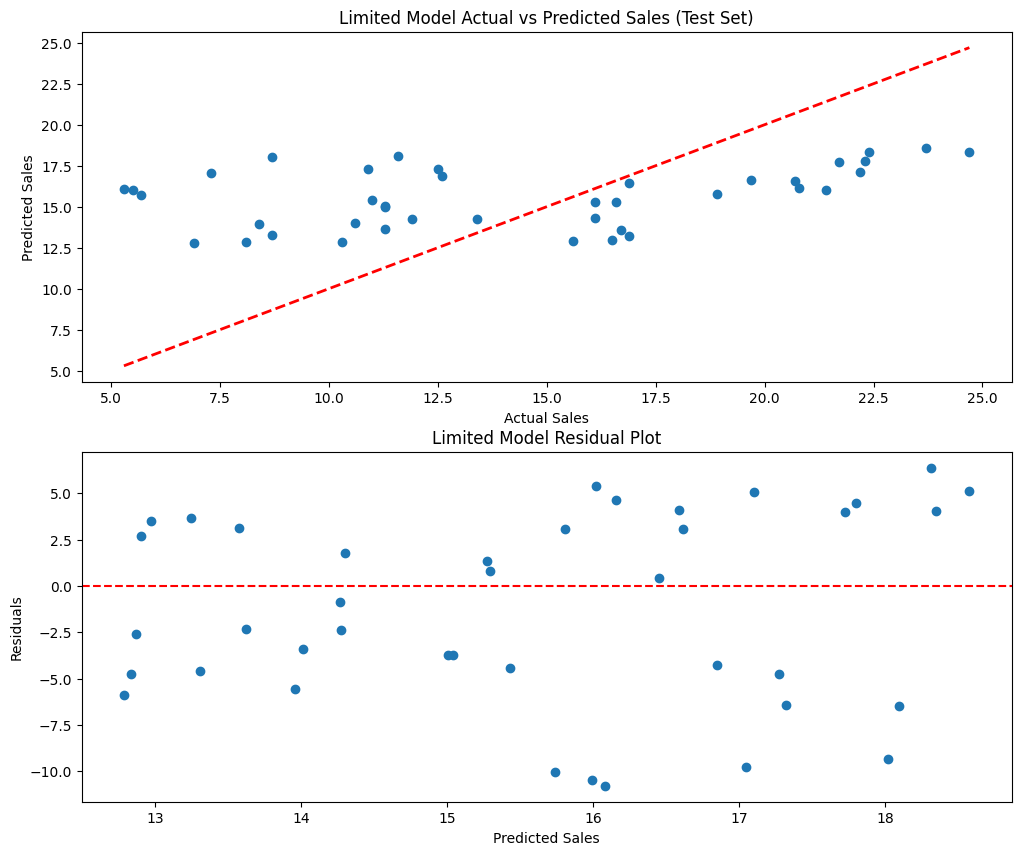

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.scatter(y_test, limited_y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Limited Model Actual vs Predicted Sales (Test Set)')

plt.subplot(2, 1, 2)
residuals = y_test - limited_y_pred_test
plt.scatter(limited_y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Limited Model Residual Plot')